In [8]:
import pandas as pd
import numpy as np
import sklearn
import time
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

pd.options.display.max_rows = 16

In [9]:
df_train = pd.read_csv('cleaned_data.csv')
df = df_train.drop(columns=['Unnamed: 0'])
df

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.000000,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.000000,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.000000,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.000000,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4082,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.000000,1
4083,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.000000,0
4084,0,48,2.0,1,20.0,0.0,0,0,0,248.0,131.0,72.0,22.00,84.0,86.000000,0
4085,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,79.447856,0


In [10]:
cate_columns = ['male', 'education','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes','TenYearCHD']
df[cate_columns] = df[cate_columns].astype('category')

In [11]:
numeric_cols = df.select_dtypes(include='number').columns
categorical_cols = df.select_dtypes(include='category').columns

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),  # Standardize numeric data
        ('cat', OneHotEncoder(), categorical_cols)  # One-hot encode categorical data
    ]
)

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=df.columns)

print("PCA Loadings:")
print(loadings)

PCA Loadings:
                      PC1       PC2       PC3       PC4       PC5       PC6  \
male            -0.037726  0.363073  0.045060  0.387528 -0.430946 -0.153672   
age              0.299888 -0.097688  0.041583  0.344103  0.322244 -0.243778   
education       -0.108525 -0.020890 -0.024450 -0.098991 -0.155228  0.457752   
currentSmoker   -0.184634  0.592001  0.026271 -0.060294  0.183612  0.053332   
cigsPerDay      -0.152897  0.635205  0.019094 -0.011170  0.107760  0.003217   
BPMeds           0.212679  0.029711 -0.054042  0.128465  0.130436  0.527368   
prevalentStroke  0.066646 -0.017213 -0.003700  0.307502  0.125711  0.563484   
prevalentHyp     0.427190  0.133416 -0.135659 -0.056102 -0.088377  0.096220   
diabetes         0.130636  0.004519  0.676206 -0.071244 -0.088260  0.046992   
totChol          0.190076  0.011083 -0.015466  0.022501  0.519342 -0.203621   
sysBP            0.477759  0.125960 -0.114861 -0.082537 -0.046871  0.029228   
diaBP            0.429076  0.163200 -0

In [16]:
important_attributes = loadings['PC1'].abs().sort_values(ascending=False)
print("Attributes contributing most to PC1:")
print(important_attributes)

Attributes contributing most to PC1:
sysBP              0.477759
diaBP              0.429076
prevalentHyp       0.427190
age                0.299888
BMI                0.276593
BPMeds             0.212679
totChol            0.190076
currentSmoker      0.184634
TenYearCHD         0.170784
cigsPerDay         0.152897
glucose            0.144978
diabetes           0.130636
heartRate          0.122435
education          0.108525
prevalentStroke    0.066646
male               0.037726
Name: PC1, dtype: float64


### Paired relation

According to the PCA results, we can have groups

1. sysBP/diaBP/prevalentHyp
2. totChol/currentSmoker
3. cigsPerDay/glucose
4. diabetes/heartRate

## XGBClassifier to decide feature

In [17]:
df

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.000000,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.000000,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.000000,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.000000,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4082,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.000000,1
4083,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.000000,0
4084,0,48,2.0,1,20.0,0.0,0,0,0,248.0,131.0,72.0,22.00,84.0,86.000000,0
4085,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,79.447856,0


In [18]:
lst_features = \
    ['male', 'currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes',              
    'age','education','cigsPerDay',
    'totChol','sysBP','diaBP','BMI','heartRate','glucose']
    
df_X = df[lst_features]
df_y = df['TenYearCHD']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_X, df_y, random_state = 0)

X_train = X_train.copy()
X_test = X_test.copy()
y_train = y_train.copy()
y_test = y_test.copy()

model = XGBClassifier(eval_metric='logloss',enable_categorical=True)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [19]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [20]:
feature_importance_df

,Feature,Importance
4,prevalentHyp,0.104311
0,male,0.103074
2,BPMeds,0.089782
6,age,0.084847
8,cigsPerDay,0.071976
1,currentSmoker,0.069643
10,sysBP,0.069488
7,education,0.067481
12,BMI,0.059168
14,glucose,0.058333


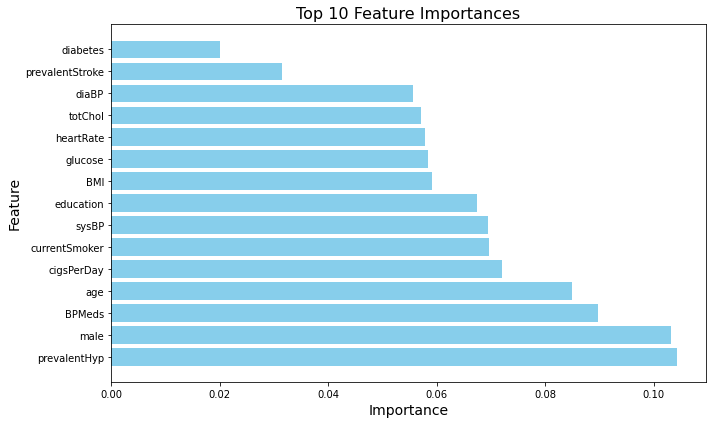

In [21]:
# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.title('Top 10 Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

In [22]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Cumulative explained variance:", cumulative_variance)

Cumulative explained variance: [0.20520493 0.32422524 0.42338251 0.49600237 0.56443188 0.63154289
 0.69450397 0.74961221 0.80272927 0.84962602 0.89199245 0.92800853
 0.9522521  0.97575959 0.98925644 1.        ]


In [24]:
explained_variance

array([0.20520493, 0.11902031, 0.09915726, 0.07261987, 0.06842951,
       0.06711101, 0.06296107, 0.05510824, 0.05311705, 0.04689676,
       0.04236643, 0.03601608, 0.02424357, 0.02350749, 0.01349685,
       0.01074356])

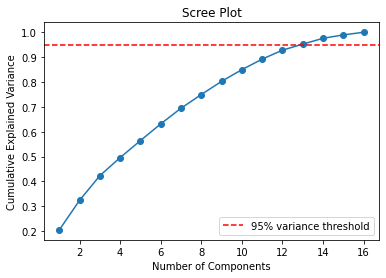

In [ ]:
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance threshold')
plt.legend()
plt.show()

## Number of PC needed

According to the last PCA result, it may need 12-13 PCs

## XGBClassifier vs PCA

### Different results from PCA and XGBClassifier?

#### PCA:
Goal: Reduces dimensionality by finding combinations of variables (principal components) that explain the maximum variance in the data.

Linear relationships: Assumes linear relationships among variables and focuses on variance structure.

Unsupervised: Does not consider the target variable.


#### XGBClassifier:
Goal: Identifies variables that are most predictive of the target variable.

Handles non-linearity: Accounts for both linear and non-linear relationships.

Supervised: Importance is evaluated with respect to the target variable.

### Conclusion

PCA does not account for the target variable, so it might emphasize variables that explain a lot of variance but are unrelated to prediction accuracy.

XGBClassifier focuses on predicting the target variable and may highlight factors with less variance but high predictive power.
